Install Dependencies

In [ ]:
!pip install openpyxl seaborn plotly

Upload Dataset

In [4]:
from google.colab import files
uploaded = files.upload()

Saving finance_economics_dataset.csv to finance_economics_dataset.csv


Import Dataset and Library

In [6]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from scipy.stats import rankdata
import matplotlib.pyplot as plt

# read dataset
file_path = "/content/finance_economics_dataset.csv"
df = pd.read_csv(file_path)

Ensure datetime parsed and sorted

In [7]:
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.sort_values('Date').reset_index(drop=True)
    df_index = df['Date']
else:
    df_index = pd.RangeIndex(start=0, stop=len(df), step=1)

Select numeric columns

In [8]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) == 0:
    raise ValueError("No numeric columns found for multivariate analysis.")

X_df = df[num_cols].copy()

If Date exists, set it as index for time interpolation

In [9]:
if 'Date' in df.columns:
    X_df.index = df['Date']

Fill missing values

In [10]:
if isinstance(X_df.index, pd.DatetimeIndex):
    X_df = X_df.interpolate(method='time', limit_direction='both')
else:
    X_df = X_df.interpolate(method='linear', limit_direction='both')

X_df = X_df.fillna(method='ffill').fillna(method='bfill')

/tmp/ipython-input-2161394258.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_df = X_df.fillna(method='ffill').fillna(method='bfill')


Standardize features

In [11]:
scaler = StandardScaler()
Xs = scaler.fit_transform(X_df.values)

IsolationForest

In [12]:
iso = IsolationForest(n_estimators=200, contamination=0.01, random_state=42)
iso.fit(Xs)
iso_pred = iso.predict(Xs)  # -1 anomaly, 1 normal
iso_df_score = -iso.decision_function(Xs)  # higher = more anomalous

LOF

In [14]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
lof_pred = lof.fit_predict(Xs)
lof_score_raw = -lof.negative_outlier_factor_  # higher = more anomalous

Normalize/rank scores

In [15]:
iso_rank = rankdata(iso_df_score, method='average') / len(iso_df_score)
lof_rank = rankdata(lof_score_raw, method='average') / len(lof_score_raw)
combined_score = (iso_rank + lof_rank) / 2.0

Build clean results_reset DataFrame

In [16]:
n = len(X_df)
results_reset = pd.DataFrame({
    'Date': list(X_df.index) if isinstance(X_df.index, pd.DatetimeIndex) else np.arange(n),
    'row': np.arange(n),
    'combined_score': combined_score,
    'iso_score': iso_df_score,
    'lof_score': lof_score_raw,
    'iso_flag': iso_pred == -1,
    'lof_flag': lof_pred == -1,
    'any_flag': (iso_pred == -1) | (lof_pred == -1)
})

Append original numeric columns

In [17]:
results_reset = pd.concat([results_reset.reset_index(drop=True), X_df.reset_index(drop=True)], axis=1)

Save Output as CSV

In [19]:
out_csv = "/content/anomaly_multivariate_results.csv"
results_reset.to_csv(out_csv, index=False)

Summary stats

Anomaly Detection Score Summary:
  n_rows: 3000
  combined_score_mean: 0.5001666666666666
  combined_score_std: 0.2707266656953439
  num_iso_anomalies: 30
  num_lof_anomalies: 30
  num_any_flag: 50


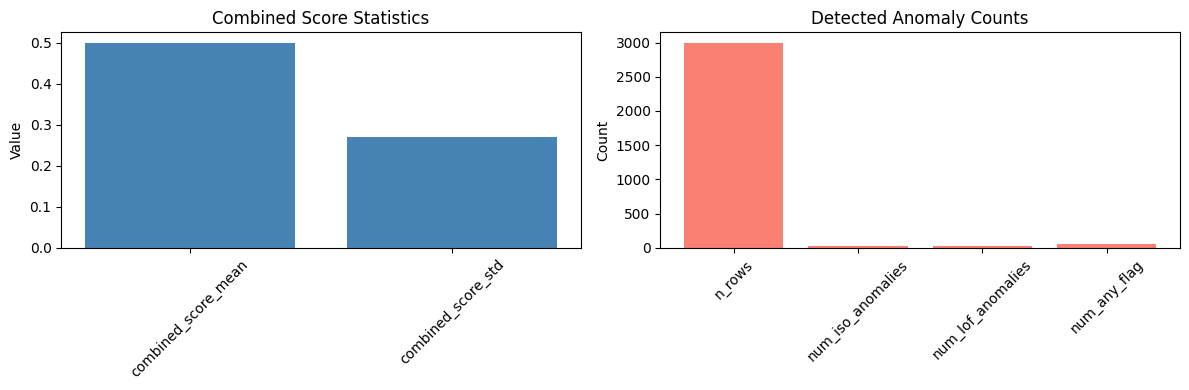

In [28]:
score_stats = {
    'n_rows': int(n),
    'combined_score_mean': float(np.mean(combined_score)),
    'combined_score_std': float(np.std(combined_score)),
    'num_iso_anomalies': int((iso_pred == -1).sum()),
    'num_lof_anomalies': int((lof_pred == -1).sum()),
    'num_any_flag': int(((iso_pred == -1) | (lof_pred == -1)).sum())
}

# Print anomaly detection summary in text format
print("Anomaly Detection Score Summary:")
for k, v in score_stats.items():
    print(f"  {k}: {v}")

# Convert the score_stats dictionary into a DataFrame for easier plotting
stats_df = pd.DataFrame(list(score_stats.items()), columns=['Metric', 'Value'])

# Separate metrics into two categories:
# 1️. Score metrics (mean, std)
# 2️. Count metrics (number of anomalies, total rows)
score_keys = [k for k in stats_df['Metric'] if 'score' in k]
count_keys = [k for k in stats_df['Metric'] if 'num' in k or 'n_rows' in k]

# Create a figure with two subplots: one for scores, one for counts
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left chart: score-related metrics
score_data = stats_df[stats_df['Metric'].isin(score_keys)]
axes[0].bar(score_data['Metric'], score_data['Value'], color='steelblue')
axes[0].set_title('Combined Score Statistics')
axes[0].set_ylabel('Value')
axes[0].tick_params(axis='x', rotation=45)

# Right chart: count-related metrics
count_data = stats_df[stats_df['Metric'].isin(count_keys)]
axes[1].bar(count_data['Metric'], count_data['Value'], color='salmon')
axes[1].set_title('Detected Anomaly Counts')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout for better readability
plt.tight_layout()
plt.show()


Top 50 anomalies

In [23]:
top_n = 50
top_df = results_reset.sort_values('combined_score', ascending=False).head(top_n).reset_index(drop=True)
print("Top 50 anomalies (multivariate, combined score)")
top_df.head(50)

Top 50 anomalies (multivariate, combined score)


,Date,row,combined_score,iso_score,lof_score,iso_flag,lof_flag,any_flag,Open Price,Close Price,...,Forex USD/EUR,Forex USD/JPY,Crude Oil Price (USD per Barrel),Gold Price (USD per Ounce),Real Estate Index,Retail Sales (Billion USD),Bankruptcy Rate (%),Mergers & Acquisitions Deals,Venture Capital Funding (Billion USD),Consumer Spending (Billion USD)
0,2006-04-17,2298,0.999833,1.715700e-02,1.171628,True,True,True,1605.78,1604.53,...,1.20,145.76,40.06,2423.86,468.92,1886,0.25,46,9.00,11377
1,2003-03-13,1167,0.998000,1.034768e-02,1.141458,True,True,True,4708.44,4699.18,...,1.43,92.34,23.31,998.98,485.04,7387,7.54,5,25.02,13766
2,2007-07-06,2743,0.997667,1.101030e-02,1.128041,True,True,True,1142.36,1165.96,...,0.80,148.99,65.49,2420.36,311.15,1222,3.82,5,19.10,2482
3,2001-12-16,715,0.997167,1.298836e-02,1.123150,True,True,True,1005.41,1023.09,...,1.01,101.50,30.01,1358.61,319.23,9887,7.15,43,98.97,14681
4,2007-05-26,2702,0.996333,1.068521e-02,1.119353,True,True,True,1293.46,1318.54,...,1.32,88.90,132.17,1010.22,495.20,4768,1.45,11,67.65,12303
5,2005-05-14,1960,0.996000,4.946341e-03,1.134966,True,True,True,1157.57,1203.17,...,1.35,135.86,133.77,1824.52,440.65,8343,0.57,47,5.11,213
6,2005-03-28,1913,0.995333,2.557069e-02,1.110700,True,True,True,1025.52,995.58,...,1.37,110.01,25.64,1129.17,155.70,2236,0.90,0,95.50,2802
7,2001-05-26,511,0.994000,3.442994e-03,1.119533,True,True,True,1249.83,1213.16,...,1.41,141.99,143.45,976.63,444.78,7994,6.36,19,82.56,7471
8,2005-11-13,2143,0.993667,1.019779e-03,1.124413,True,True,True,1377.68,1405.15,...,1.49,138.88,82.99,1654.45,211.55,1582,1.17,0,94.31,522
9,2007-05-11,2687,0.993333,-5.263845e-04,1.136603,False,True,True,1557.02,1581.74,...,0.91,99.03,42.47,2321.00,299.91,610,7.09,7,3.66,463


Plot combined score time series and mark top anomalies

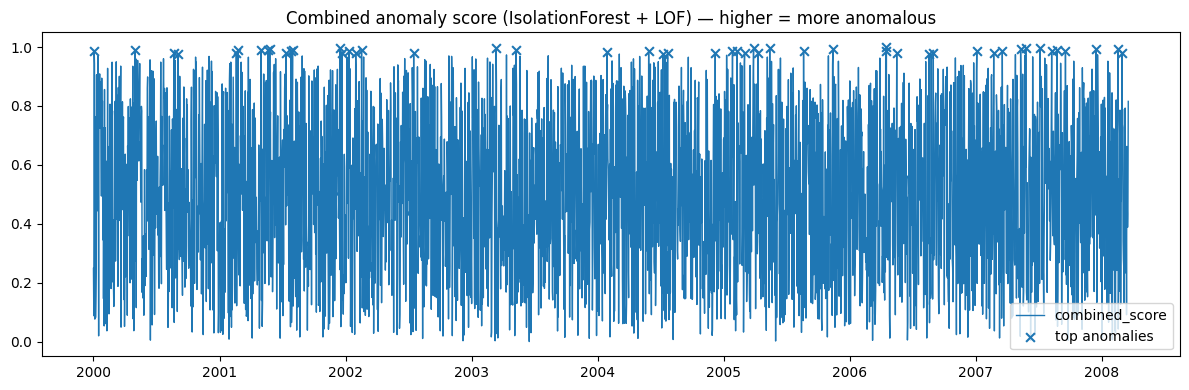

Saved multivariate anomaly results to: /content/anomaly_multivariate_results.csv


In [29]:
plt.figure(figsize=(12,4))
plt.plot(results_reset['Date'], results_reset['combined_score'], linewidth=1, label='combined_score')

# mark top anomalies
top_dates = top_df['Date']
if len(top_dates) > 0:
    plt.scatter(top_dates, top_df['combined_score'], marker='x', s=40, label='top anomalies')
plt.title("Combined anomaly score (IsolationForest + LOF) — higher = more anomalous")
plt.legend()
plt.tight_layout()
plt.show()

print("Saved multivariate anomaly results to:", out_csv)